In [1]:
!pip install pandas seaborn matplotlib numpy openpyxl catboost matplotlib scikit-learn tensorflow keras

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 1.9 MB/s eta 0:00:06
   --- ------------------------------------ 1.0/11.0 MB 1.8 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/11.0 MB 1.8 MB/s eta 0:00:06
   ------ --------------------------------- 1.8/11.0 MB 1.8 MB/s eta 0:00:05
   ------- -------------------------------- 2.1/11.0 MB 1.8 MB/s eta 0:00:05
   --------- ------------------------------ 2.6/11.0 MB 1.9 MB/s eta 0:00:05
   ----------- ---------------------------- 3.1/11.0 MB 2.0 MB/s eta 0:00:04
   ------------- -------------------------- 3.7/11.0 MB 2.0 MB/s eta 0:00:04
   --------------- ------------------------ 4.2/11.0 MB 2.1 MB/s eta 0:00:04
   ----------------- ---------------------- 4.7/11.0 MB 2.1 MB/s eta 0:00:03
   ------------------- -------------------- 5.2/11.0 MB 2.2 MB/s eta 0:00:03
   ----------


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl 
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib 
import numpy as np  
from sklearn.preprocessing import StandardScaler  
from tensorflow import keras  
from tensorflow.keras import layers  
  


Continuous columns retained count:
83
Correlation matrix shape:
(83, 83)


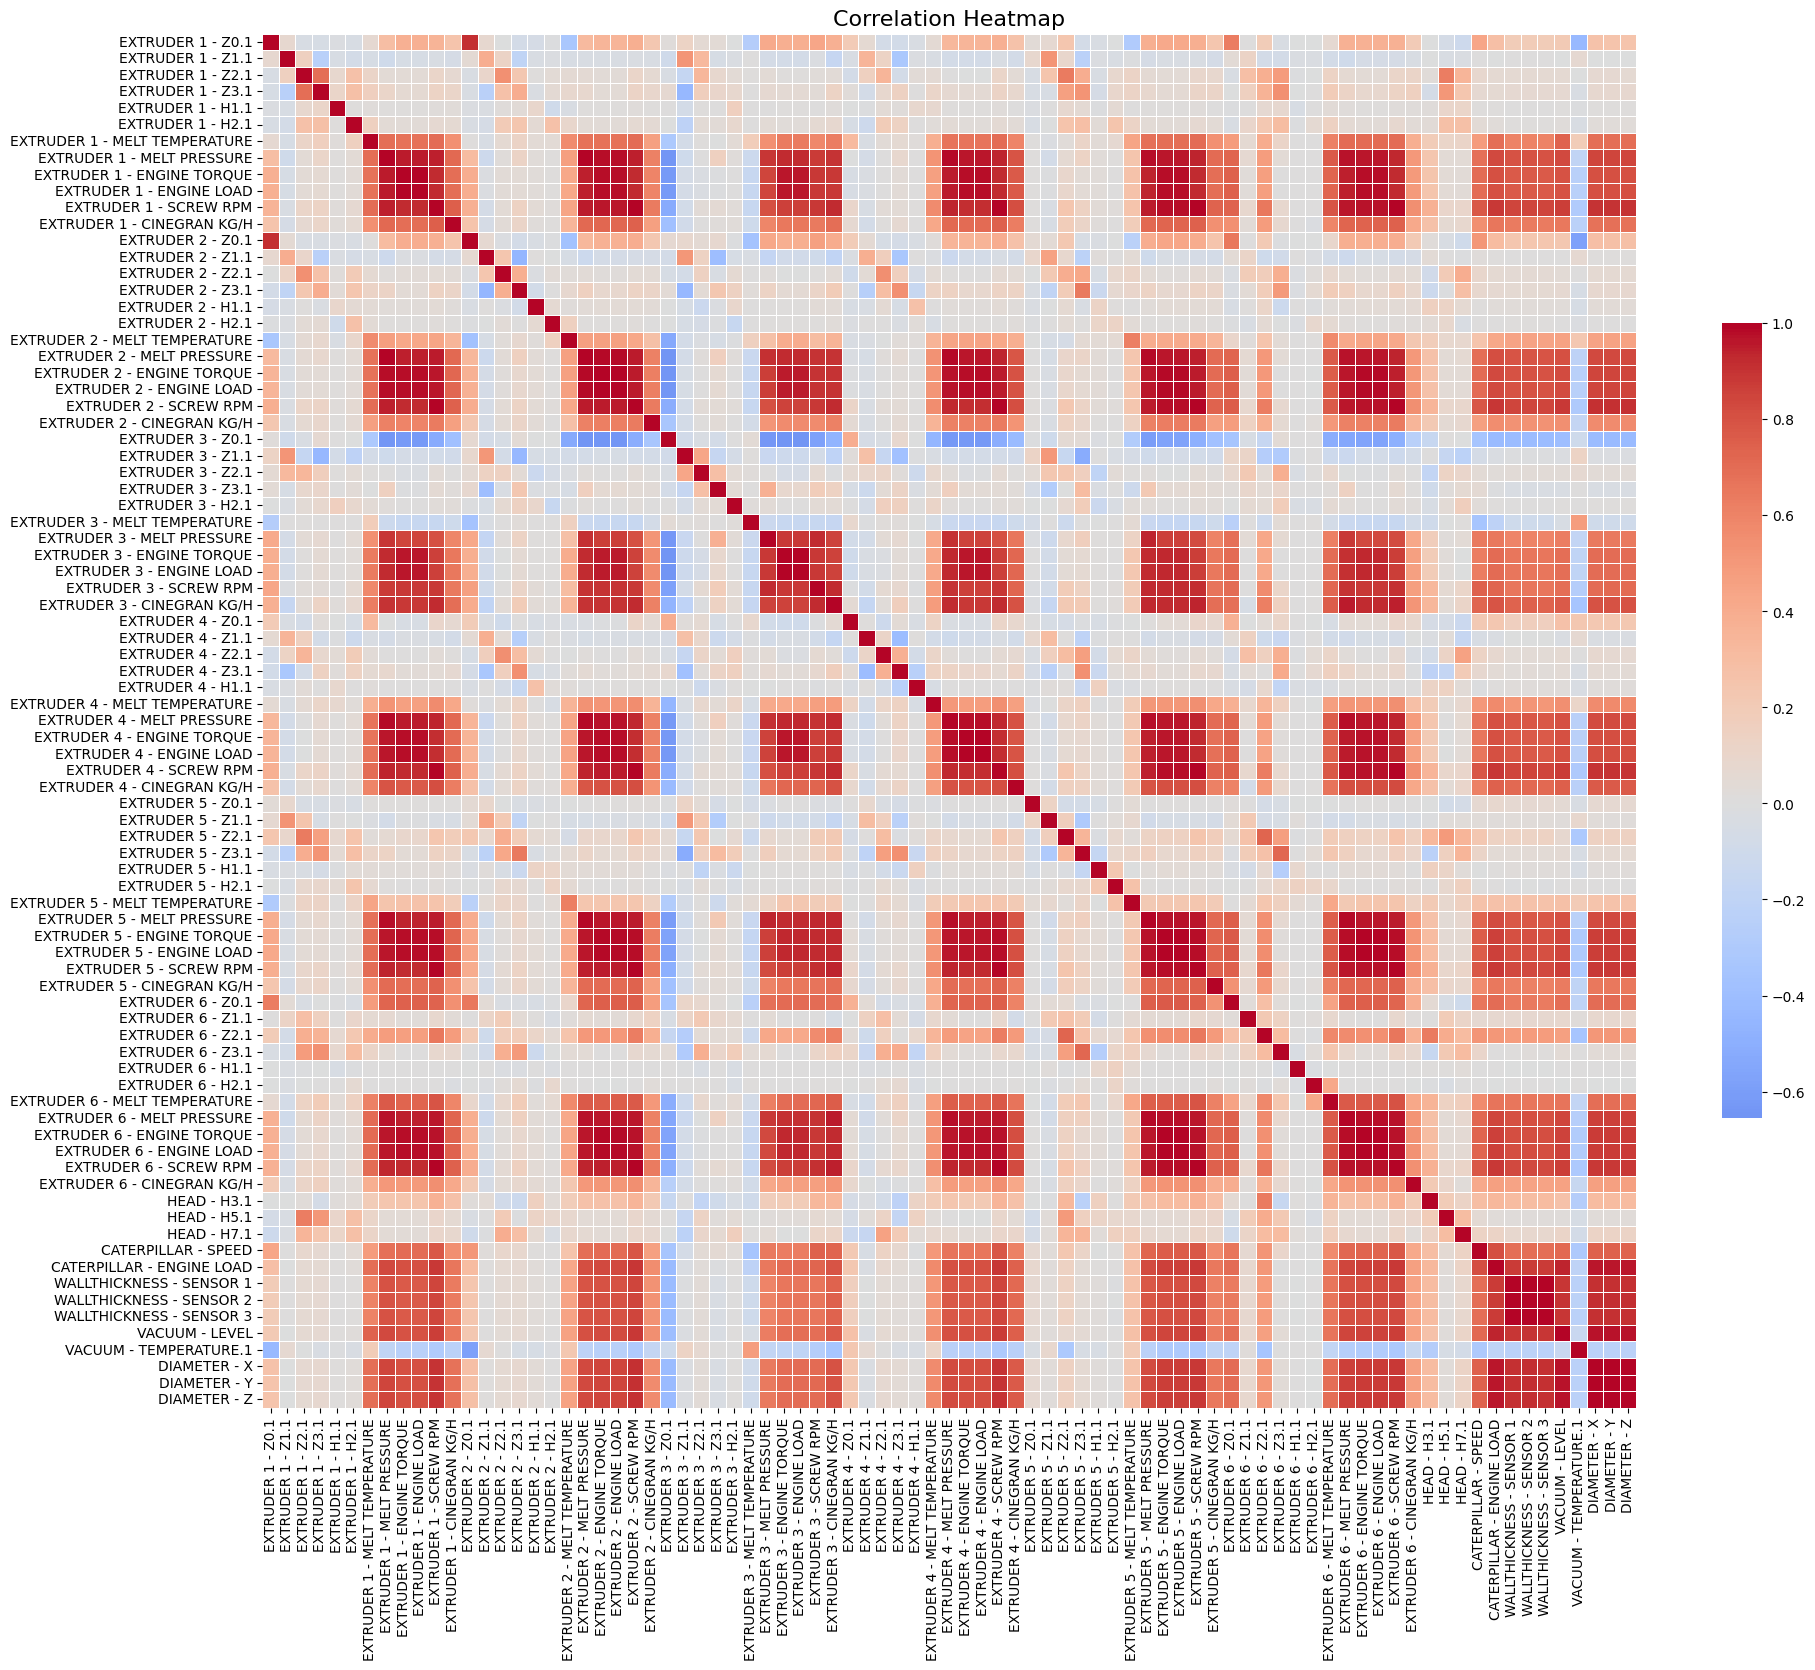

In [85]:
file_path = 'filled_dataset_corrected.xlsx'
df = pd.read_excel(file_path)

# Coerce numeric
for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')

numeric_df = df.select_dtypes(include='number')

# Drop constant columns
non_constant_df = numeric_df.loc[:, numeric_df.nunique(dropna=False) > 1]

# Define continuous: more than 10 unique values or unique ratio > 0.02
cont_cols = [c for c in non_constant_df.columns if (non_constant_df[c].nunique() > 10) or (non_constant_df[c].nunique()/len(non_constant_df) > 0.02)]
continuous_df = non_constant_df[cont_cols]

print('Continuous columns retained count:')
print(len(cont_cols))

corr_cont = continuous_df.corr()
print('Correlation matrix shape:')
print(corr_cont.shape)

plt.figure(figsize=(20, 18))
ax = sns.heatmap(corr_cont, cmap='coolwarm', center=0, square=True, linewidths=.4, cbar_kws={'shrink': .5})
ax.set_title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

BG index (0-based):
58
EP index (0-based):
145
Subset columns count:
88


C:\Users\KONVI\AppData\Local\Temp\ipykernel_21548\489769826.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_series.index, y=mean_series.values, palette='magma')


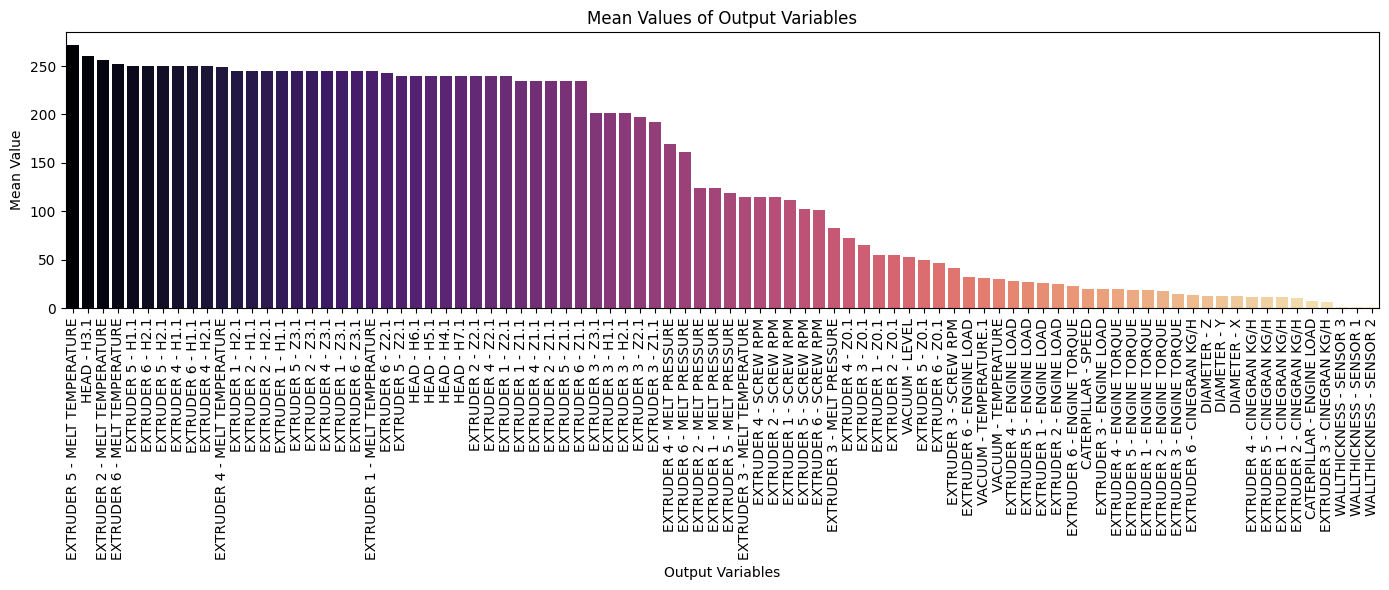

In [86]:
# Helper to convert Excel letter to index (0-based)
def excel_col_to_index(col):
    col = col.upper()
    exp = 0
    idx = 0
    for char in reversed(col):
        idx += (ord(char) - 64) * (26 ** exp)
        exp += 1
    return idx - 1  # zero-based

bg_idx = excel_col_to_index('BG')
ep_idx = excel_col_to_index('EP')
print('BG index (0-based):')
print(bg_idx)
print('EP index (0-based):')
print(ep_idx)

file_path = 'filled_dataset_corrected.xlsx'
df = pd.read_excel(file_path)

subset_df = df.iloc[:, bg_idx:ep_idx+1]

# Coerce to numeric
subset_df = subset_df.apply(pd.to_numeric, errors='coerce')

mean_series = subset_df.mean().sort_values(ascending=False)
print('Subset columns count:')
print(len(mean_series))

# Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(x=mean_series.index, y=mean_series.values, palette='magma')
plt.xticks(rotation=90)
plt.xlabel('Output Variables')
plt.ylabel('Mean Value')
plt.title('Mean Values of Output Variables')
plt.tight_layout()
plt.savefig('mean_values_of_output_variables.png')
plt.show()

In [93]:

# Exclude the first column (timestamp) and separate features and target
X = df.iloc[:, 1:-1]  # All columns except the first (Date/Heure) and last (target)
y = df.iloc[:, -1]    # Last column as target ("SCRAP MODE - 0=scrap 1-prod")


In [94]:

# Identify categorical features (e.g., columns containing "MATERIAL")
cat_features = [col for col in X.columns if 'MATERIAL' in col]


In [95]:

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [96]:

# Create CatBoost Pool for training and testing data
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Define CatBoost parameters (customizable)
params = {
    'iterations': 1000,          # Number of boosting iterations
    'learning_rate': 0.01,       # Learning rate
    'depth': 6,                  # Depth of the trees
    'loss_function': 'Logloss',  # Binary classification loss function
    'verbose': 100,              # Print progress every 100 iterations
    'random_seed': 42,           # For reproducibility
    'l2_leaf_reg': 3.0,          # L2 regularization coefficient
    'bagging_temperature': 1.0,  # Controls intensity of Bayesian bagging
    'border_count': 32           # Number of splits for numerical features
}

# Initialize and train the CatBoost model
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.6624138	test: 0.6624575	best: 0.6624575 (0)	total: 20.1ms	remaining: 20.1s
100:	learn: 0.0394353	test: 0.0400784	best: 0.0400784 (100)	total: 863ms	remaining: 7.68s
200:	learn: 0.0169003	test: 0.0178668	best: 0.0178668 (200)	total: 1.7s	remaining: 6.76s
300:	learn: 0.0113890	test: 0.0129261	best: 0.0129261 (300)	total: 2.47s	remaining: 5.75s
400:	learn: 0.0083215	test: 0.0101905	best: 0.0101905 (400)	total: 3.26s	remaining: 4.86s
500:	learn: 0.0066048	test: 0.0086508	best: 0.0086508 (500)	total: 4.02s	remaining: 4s
600:	learn: 0.0052922	test: 0.0074484	best: 0.0074484 (600)	total: 4.77s	remaining: 3.17s
700:	learn: 0.0043533	test: 0.0066524	best: 0.0066524 (699)	total: 5.52s	remaining: 2.36s
800:	learn: 0.0037122	test: 0.0060649	best: 0.0060649 (800)	total: 6.26s	remaining: 1.55s
900:	learn: 0.0032960	test: 0.0057006	best: 0.0057006 (900)	total: 6.97s	remaining: 766ms
999:	learn: 0.0030277	test: 0.0054572	best: 0.0054572 (999)	total: 7.65s	remaining: 0us

bestTest = 0.00545

In [97]:

# Make predictions on the test set
y_pred = model.predict(X_test)


In [98]:

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Evaluation on Test Data:\nAccuracy: {accuracy:.4f}\n")


Model Evaluation on Test Data:
Accuracy: 0.9985



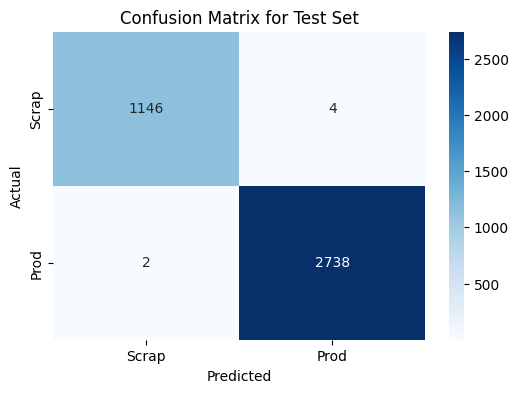

In [99]:

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Scrap', 'Prod'], yticklabels=['Scrap', 'Prod'])
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:

# Print classification report
print("Classification Report for Test Set:\n", classification_report(y_test, y_pred, target_names=['Scrap', 'Prod']))


Classification Report for Test Set:
               precision    recall  f1-score   support

       Scrap       1.00      1.00      1.00      1150
        Prod       1.00      1.00      1.00      2740

    accuracy                           1.00      3890
   macro avg       1.00      1.00      1.00      3890
weighted avg       1.00      1.00      1.00      3890



In [13]:

# Feature importance
feature_importance = model.get_feature_importance(train_pool)
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", importance_df)



Feature Importance:
                    Feature  Importance
117      EXTRUDER 6 - Z0.1   18.681556
57       EXTRUDER 1 - Z0.1    9.516255
134    CATERPILLAR - SPEED    7.117373
144           DIAMETER - Z    6.348796
139         VACUUM - LEVEL    4.948947
..                     ...         ...
44            DIAMETER MIN    0.000000
45        DIAMETER NOMINAL    0.000000
46            DIAMETER MAX    0.000000
47   EXTRUDER 1 - MATERIAL    0.000000
140   VACUUM - TEMPERATURE    0.000000

[145 rows x 2 columns]


C:\Users\KONVI\AppData\Local\Temp\ipykernel_21548\3725091717.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='magma')


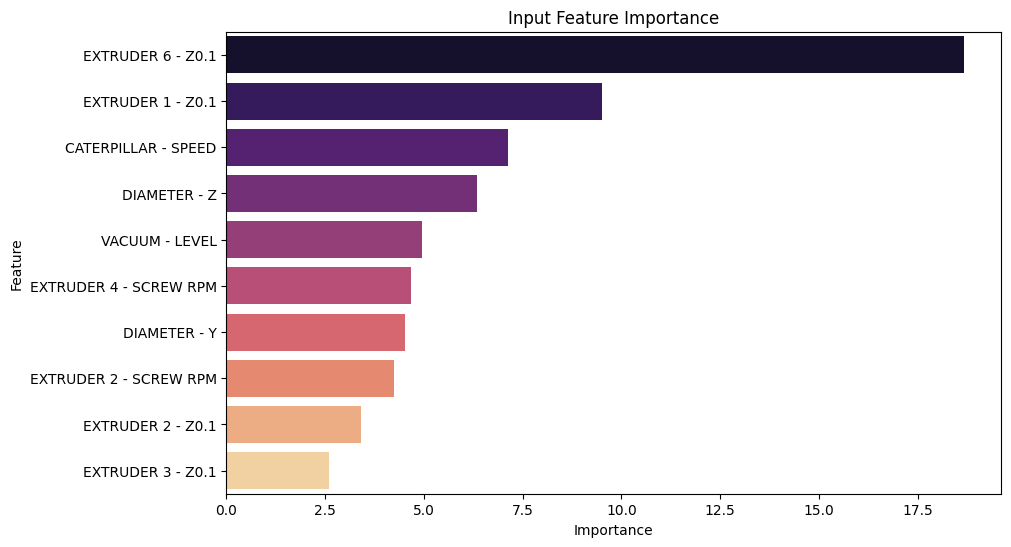

In [88]:

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='magma')
plt.title('Input Feature Importance')
plt.savefig('input_feature_importance.png')
plt.show()


In [40]:
# 1) Load data and isolate BG‒EP  
file_path = 'filled_dataset_corrected.xlsx'  
df_full     = pd.read_excel(file_path)  
  
def excel_col_to_index(col):  
    col = col.upper(); exp = 0; idx = 0  
    for char in reversed(col):  
        idx += (ord(char) - 64) * (26 ** exp); exp += 1  
    return idx - 1                # zero-based  
  
start_i = excel_col_to_index('BG')  
end_i   = excel_col_to_index('EP')  
df      = df_full.iloc[:, start_i:end_i+1]  
  


In [41]:
# 2) Coerce to numeric, drop rows with all-NaNs  
df      = df.apply(pd.to_numeric, errors='coerce')  
df.dropna(how='all', inplace=True)  
 

In [42]:
 
# 3) Scale features  
scaler   = StandardScaler()  
data_np  = scaler.fit_transform(df.values.astype(float))  
  


In [43]:
# 4) Create sliding windows  
SEQ_LEN = 30          # 30-step window (≈ one shift/hour/day etc.)  
def create_windows(arr, seq_len):  
    X = []  
    for i in range(len(arr) - seq_len + 1):  
        X.append(arr[i : i+seq_len])  
    return np.array(X)  
  
X_all = create_windows(data_np, SEQ_LEN)  
train_size = int(0.70 * len(X_all))  
  
X_train = X_all[:train_size]  
X_test  = X_all[train_size:]  
  


In [44]:
# 5) Build & train LSTM auto-encoder  
n_features = X_train.shape[2]  
inputs     = keras.Input(shape=(SEQ_LEN, n_features))  
x          = layers.LSTM(128, return_sequences=True)(inputs)  
x          = layers.LSTM(64,  return_sequences=False)(x)  
x          = layers.RepeatVector(SEQ_LEN)(x)  
x          = layers.LSTM(64,  return_sequences=True)(x)  
x          = layers.LSTM(128, return_sequences=True)(x)  
outputs    = layers.TimeDistributed(layers.Dense(n_features))(x)  
  
model = keras.Model(inputs, outputs, name='lstm_autoenc')  
model.compile(optimizer='adam', loss='mse')  
print(model.summary())  
  
EPOCHS = 30  
model.fit(X_train, X_train,  
          epochs=EPOCHS,  
          batch_size=64,  
          validation_split=0.1,  
          shuffle=True,  
          verbose=1)  
  


Model: "lstm_autoenc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 30, 88)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 30, 128)        │       111,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 88)         │        11,352 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,704 (1.16 MB)

 Trainable params: 303,704 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - loss: 0.3862 - val_loss: 1.4484
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.2691 - val_loss: 1.7561
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.2434 - val_loss: 1.4206
Epoch 4/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.2207 - val_loss: 1.4742
Epoch 5/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.1981 - val_loss: 1.4397
Epoch 6/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.1874 - val_loss: 1.5540
Epoch 7/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.1770 - val_loss: 1.4789
Epoch 8/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.1608 - val_loss: 1.5052
Epoch 9/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.1611 - val_loss: 1.5352
Epoch 10/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.1477 - val_loss: 1.4807
Epoch 11/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.1379 - val_loss: 1.5686
Epoch 12/30
192/192 ━━━━━

In [80]:
# --- Step 6: Identify Top 5 Most Anomalous Features ---

# Get model's predictions on the test data
X_test_pred = model.predict(X_test)

# Calculate the squared error for every data point in the test set
# Shape: (num_windows, sequence_length, num_features)
test_squared_error = np.square(X_test_pred - X_test)

# Calculate the overall reconstruction error per window to find which windows are anomalous
recon_error_per_window = np.mean(test_squared_error, axis=(1, 2))
threshold = np.percentile(recon_error_per_window, 85) # 95th percentile threshold

# Find the windows that are considered anomalous
anomalous_window_indices = np.where(recon_error_per_window > threshold)[0]

# Now, focus only on the errors from these anomalous windows
anomalous_errors = test_squared_error[anomalous_window_indices]

# Sum the errors per feature across all anomalous windows to find which features contributed most
feature_contribution = np.sum(anomalous_errors, axis=(0, 1))

# Get the indices of the top 5 features
# np.argsort returns indices from smallest to largest, so we take the last 5
top_10_feature_indices = np.argsort(feature_contribution)[-10:]
top_10_feature_names = df.columns[top_10_feature_indices]

print(f"Top 10 most anomalous features: {list(top_10_feature_names)}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Top 10 most anomalous features: ['EXTRUDER 3 - Z0.1', 'EXTRUDER 2 - SCREW RPM', 'CATERPILLAR - SPEED', 'EXTRUDER 4 - SCREW RPM', 'DIAMETER - Z', 'DIAMETER - Y', 'VACUUM - LEVEL', 'EXTRUDER 6 - Z0.1', 'EXTRUDER 1 - Z0.1', 'EXTRUDER 2 - Z0.1']


In [81]:
# --- Step 7 (Modified): Create the Per-Feature Anomaly Heatmap DataFrame ---

# We need to map the windowed errors back to the original timestamps.
# Since windows overlap, we average the errors for each timestamp.

# Create an empty matrix to store the unrolled anomaly scores for the test set
num_test_samples_for_unrolling = len(X_test) + SEQ_LEN - 1
num_features = X_test.shape[2]
unrolled_scores = np.zeros((num_test_samples_for_unrolling, num_features))
counts = np.zeros((num_test_samples_for_unrolling, num_features))

# Loop through each window's squared error and add it to the correct time step
for i, window_error in enumerate(test_squared_error):
    # The error for this window applies to the time steps from i to i + SEQ_LEN
    unrolled_scores[i : i + SEQ_LEN, :] += window_error
    counts[i : i + SEQ_LEN, :] += 1

# Average the scores by dividing by the count of overlaps
# This gives a smooth error for each feature at each time step
final_scores = unrolled_scores / counts

# Filter for only the top 5 features
top_5_scores = final_scores[:, top_10_feature_indices]

# Create a DataFrame for easier plotting with seaborn
# The test_timestamps should cover the exact span of the unrolled scores in the original df
test_timestamps = df.index[train_size : train_size + num_test_samples_for_unrolling]
heatmap_df = pd.DataFrame(top_5_scores, columns=top_10_feature_names, index=test_timestamps)

# --- NEW: Resample/Reduce timestamps for the heatmap ---
# Ensure the index is a DatetimeIndex for resampling
if not isinstance(heatmap_df.index, pd.DatetimeIndex):
    heatmap_df.index = pd.to_datetime(heatmap_df.index)

# To limit to approximately 10 timestamps, we select evenly spaced points.
current_num_timestamps = len(heatmap_df)
if current_num_timestamps > 10:
    # Calculate a step size to get roughly 10 timestamps
    step_size = max(1, current_num_timestamps // 9)
    selected_indices = np.arange(0, current_num_timestamps, step_size)
    heatmap_df_reduced = heatmap_df.iloc[selected_indices]
else:
    # If already 10 or fewer, use the DataFrame as is
    heatmap_df_reduced = heatmap_df.copy()

# Format timestamps to be more concise and readable on the x-axis
# Using '%H:%M:%S' for a more detailed look or '%H:%M' if seconds are not critical.
# Given the previous chart had seconds, I'll keep it, but it will be sparse.
heatmap_df_reduced.index = heatmap_df_reduced.index.strftime('%H:%M:%S')

# --- NEW: Transpose the DataFrame for plotting ---
# This puts features on the y-axis and timestamps on the x-axis
heatmap_plot_data = heatmap_df_reduced.T

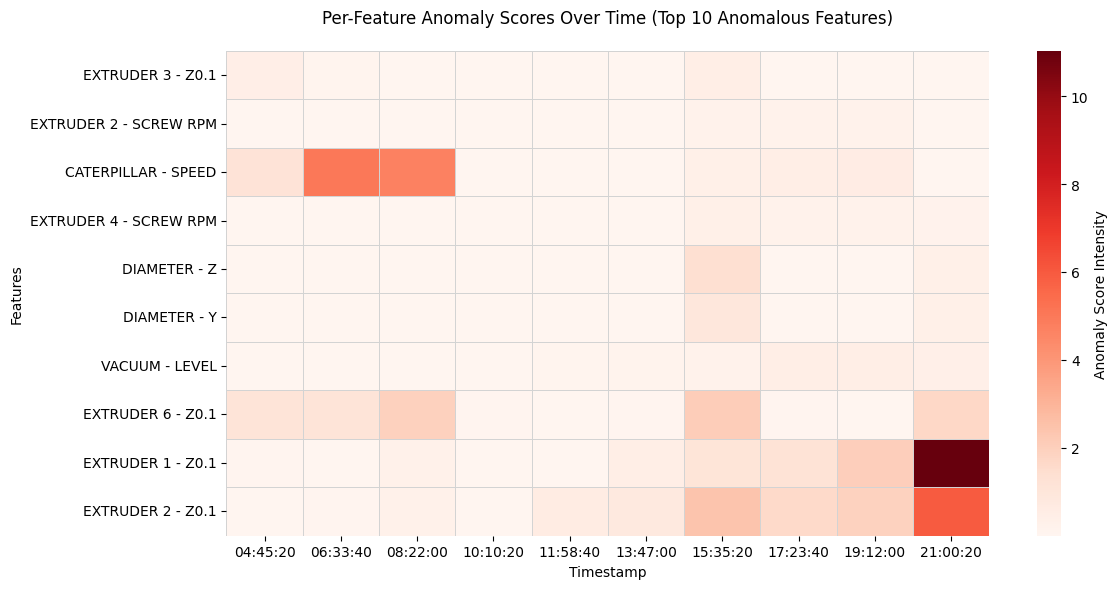

In [89]:
# --- Step 8 (Modified): Visualization ---

plt.style.use('default')
# Adjust figure size for better display of the transposed heatmap
fig, ax = plt.subplots(figsize=(12, 6)) # Increased width for timestamps

sns.heatmap(heatmap_plot_data,
            cmap='Reds',
            cbar_kws={'label': 'Anomaly Score Intensity'},
            ax=ax,
            linewidths=.5, # Add lines between cells for better separation
            linecolor='lightgray' # Color of the lines
           )

ax.set_title('Per-Feature Anomaly Scores Over Time (Top 10 Anomalous Features)', pad=20)
ax.set_xlabel('Timestamp') # X-axis now shows timestamps
ax.set_ylabel('Features')   # Y-axis now shows feature names

# Optional: Rotate x-axis labels if they overlap, though with <=10 it should be fine.
# plt.xticks(rotation=45, ha='right')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig('anomaly_heatmap.png')
plt.show()


In [83]:
# 6) Reconstruction error & threshold  
X_test_pred   = model.predict(X_test)  
recon_error   = np.mean(np.square(X_test_pred - X_test), axis=(1,2))  
threshold     = np.percentile(recon_error, 85)     # top 5 % flagged  
anomaly_mask  = recon_error > threshold  


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


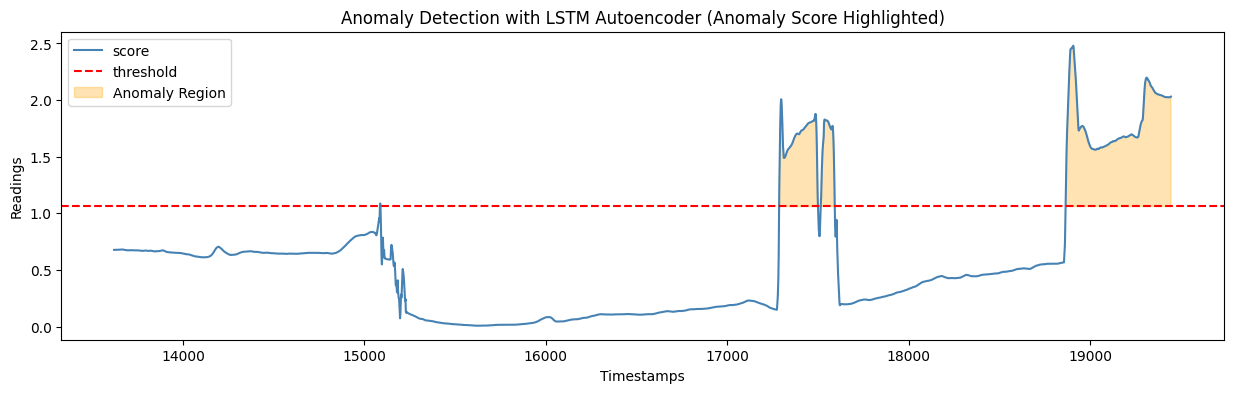

In [100]:
# 7) Visualisation  
scores_series = pd.Series(recon_error, name='score')  
scores_series.index = df.index[SEQ_LEN-1:][train_size:]  
fig, ax = plt.subplots(figsize=(15, 4))  
scores_series.plot(color='steelblue', ax=ax)  
ax.axhline(threshold, color='red', linestyle='--', label='threshold')
ax.fill_between(scores_series.index, scores_series.values, threshold,
                where=(scores_series.values > threshold),
                color='orange', alpha=0.3, label='Anomaly Region') 
ax.set_xlabel('Timestamps') # X-axis now shows timestamps
ax.set_ylabel('Readings')   # Y-axis now shows feature names 
ax.set_title('Anomaly Detection with LSTM Autoencoder (Anomaly Score Highlighted)')  
ax.legend()  
plt.savefig('reconstruction_error_anomaly_scores.png')
plt.show()  



In [28]:

# Save the model and feature columns
model.save_model('scrap_mode_catboost_model.cbm')
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')


['feature_columns.pkl']

In [29]:

# Example: Predicting on new test data (assuming new data is in the same format)
# Load new test data (for demonstration, reusing X_test here)
new_data = X_test  # Replace with actual new test data if available
new_pool = Pool(new_data, cat_features=cat_features)
new_predictions = model.predict(new_pool)

# Print sample predictions
print("\nSample Predictions on Test Data:\n", new_predictions[:10])


Sample Predictions on Test Data:
 [1 0 1 1 1 0 1 0 1 1]
